In [4]:
%run init_notebook.py

In [5]:
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA

In [6]:
from src.processing import srs_get_ytm
from src.utils import get_samp, get_dt_index, load_pd_df

In [7]:
# interest rates

In [8]:
df = pd.read_csv(os.path.join(DATA_DIR, 'ecb_interest_rates.csv'), low_memory=False)
df = df[df['REF_AREA'] == 'DE'].dropna(axis=1)
df['date'] = df['TIME_PERIOD'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df = df[df['TITLE'] == list(set(df['TITLE']))[1]]
df.set_index('date', inplace=True)

mir = df[['OBS_VALUE']].rename(columns={'OBS_VALUE': 'mir'}) / 100

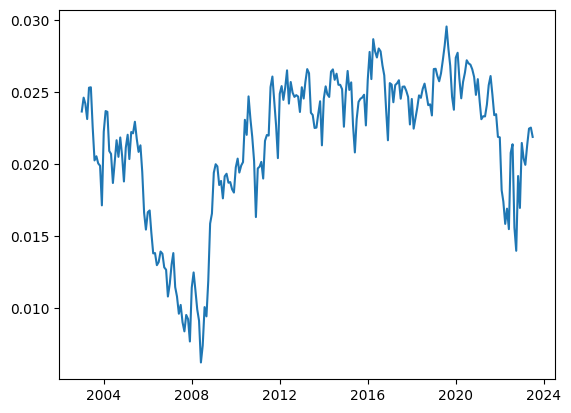

In [9]:
plt.plot(mir)

In [10]:
# bei

In [11]:
_deI = pd.read_excel(os.path.join(DATA_DIR, 'bund_inflation.xlsx'), sheet_name='DE0001030575')
_deB = pd.read_excel(os.path.join(DATA_DIR, 'bund_inflation.xlsx'), sheet_name='DE0001102341')

bei = pd.concat([_deI.set_index('Date')['Close'].rename('10yI'), _deB.set_index('Date')['Close'].rename('10yB')], axis=1).sort_index()
bei.index.rename('date', inplace=True)
bei *= 100

bei_fr = pd.read_excel(os.path.join(DATA_DIR, 'break_even_inflation.xls'), skiprows=5)
bei_fr.set_index('Unnamed: 0', inplace=True)
bei_fr.index.rename('date', inplace=True)
bei_fr.columns = ['OAT', 'OATI', 'bei_fr']

In [12]:
bei['10yB_ymt'] = srs_get_ytm(bei['10yB'], maturity_date=datetime(2046, 8, 15), coupon=2.5, fac_v_scale=100)
bei['10yI_ymt'] = srs_get_ytm(bei['10yI'], maturity_date=datetime(2045, 4, 15), coupon=0.122, fac_v_scale=100)

Overall solver residuals: mean [-1.79820264e-10], std: [7.69338601e-10]
Overall solver residuals: mean [7.42683317e-12], std: [6.54465437e-10]


In [13]:
bei['bei'] = bei['10yB_ymt'] - bei['10yI_ymt']

In [14]:
infl = get_dt_index(load_pd_df('de_inf_prepro.csv'))
bei = bei.join(infl[['pi_de_surprise_Y', 'pi_de_surprise']] )

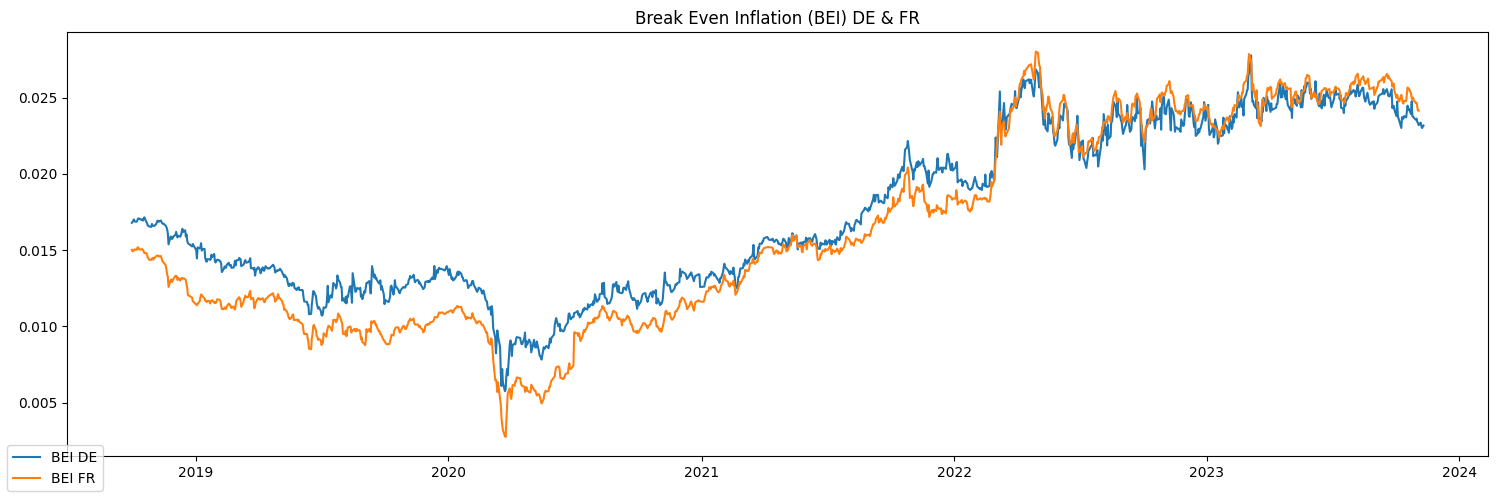

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(bei.bei, label='BEI DE')
ax.plot(bei_fr.loc[[i for i in bei.index if i in bei_fr.index]].bei_fr, label='BEI FR')

# ax.twinx().plot(bei.pi_de_surprise_Y.dropna(), color='green', label='annual surprise infl.')
# ax.plot(bei.pi_de_surprise.dropna(), color='black', label='monthly surprise infl.')

plt.title("Break Even Inflation (BEI) DE & FR")
fig.legend(loc='lower left')

plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph5.png'))


In [23]:
bei.to_feather(os.path.join(DATA_DIR, 'bei_data.feather'))

In [24]:
ARIMA(bei.bei.diff().values, order=(3,0,0)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1300
Model:                 ARIMA(3, 0, 0)   Log Likelihood                8141.129
Date:                Tue, 06 Feb 2024   AIC                         -16272.258
Time:                        16:53:18   BIC                         -16246.407
Sample:                             0   HQIC                        -16262.559
                               - 1300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.636e-06   8.66e-06      0.535      0.592   -1.23e-05    2.16e-05
ar.L1         -0.2515      0.017    -15.150      0.000      -0.284      -0.219
ar.L2         -0.1380      0.020     -7.024      0.000      -0.176      -0.099
ar.L3         -0.0843      0.019     -4.516      0.000      -0.121      -0.048
sigma2       2.11e-07   4.82e-09     43.744      0.000    2.02e-07     2.2e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1164.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
bei.to_csv(os.path.join(DATA_DIR, 'bei.csv'))